# Assignment-9 - Using a dataset with ~3,000 images of handwritten Roman numerals (1–10), build a convolutional neural network (ConvNet), then use transfer learning and fine tuning to improve the model, if possible.



In [39]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [40]:
batch_size = 16
img_height = 225
img_width = 225

In [41]:
training_dir = "train"

In [42]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2067 files belonging to 10 classes.


In [43]:
val_dir = "val"

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 813 files belonging to 10 classes.


In [45]:
train_ds.class_names

['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']

In [46]:
num_classes = len(train_ds.class_names)
num_classes

10

In [47]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [48]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [49]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])

In [51]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [52]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
130/130 [==============================] - 149s 1s/step - loss: 2.2256 - accuracy: 0.1974 - val_loss: 2.1500 - val_accuracy: 0.2177
Epoch 2/5
130/130 [==============================] - 153s 1s/step - loss: 1.6537 - accuracy: 0.4499 - val_loss: 1.8827 - val_accuracy: 0.3358
Epoch 3/5
130/130 [==============================] - 152s 1s/step - loss: 1.0560 - accuracy: 0.6720 - val_loss: 1.9429 - val_accuracy: 0.3776
Epoch 4/5
130/130 [==============================] - 138s 1s/step - loss: 0.5796 - accuracy: 0.8529 - val_loss: 2.0322 - val_accuracy: 0.3813
Epoch 5/5
130/130 [==============================] - 140s 1s/step - loss: 0.3639 - accuracy: 0.9221 - val_loss: 1.9573 - val_accuracy: 0.4084


# Transfer learning

In [53]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [54]:
IMG_SIZE = (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [55]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 8, 8, 1280)


In [56]:
base_model.trainable = False

In [57]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 225, 225, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 113, 113, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 113, 113, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 57, 57, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 59, 59, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 29, 29, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 29, 29, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 15, 15, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 15, 15, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 15, 15, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 15, 15, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 15, 15, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 15, 15, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 15, 15, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 15, 15, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

# Add a classification head

In [58]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [59]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 10)


In [60]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [61]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [62]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\Bharani\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [63]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 225, 225, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 225, 225, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 225, 225, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                           

In [64]:
len(model.trainable_variables)

2

# Test the model

In [65]:
loss0, accuracy0 = model.evaluate(val_ds)

51/51 [==============================] - 47s 823ms/step - loss: 2.7062 - accuracy: 0.0763


In [66]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.71
initial accuracy: 0.08


In [67]:
initial_epochs = 5
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/5
130/130 [==============================] - 161s 1s/step - loss: 2.4096 - accuracy: 0.1287 - val_loss: 2.2289 - val_accuracy: 0.1636
Epoch 2/5
130/130 [==============================] - 142s 1s/step - loss: 2.1996 - accuracy: 0.1945 - val_loss: 2.0793 - val_accuracy: 0.2423
Epoch 3/5
130/130 [==============================] - 131s 1s/step - loss: 2.0326 - accuracy: 0.2782 - val_loss: 1.9641 - val_accuracy: 0.2964
Epoch 4/5
130/130 [==============================] - 138s 1s/step - loss: 1.8930 - accuracy: 0.3387 - val_loss: 1.8797 - val_accuracy: 0.3346
Epoch 5/5
130/130 [==============================] - 132s 1s/step - loss: 1.8088 - accuracy: 0.3706 - val_loss: 1.7959 - val_accuracy: 0.3825


# Learning curves

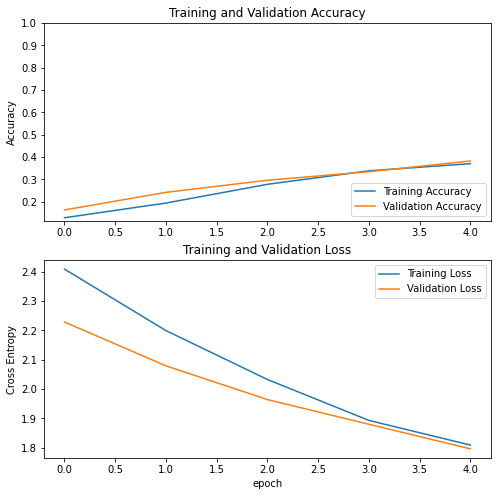

In [68]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

# Un-freeze the top layers of the model

In [69]:
base_model.trainable = True

In [70]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


# Compile the model

In [71]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 225, 225, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 225, 225, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 225, 225, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                           

# Continue training the model

In [73]:
history.epoch[-1]

4

In [74]:
fine_tune_epochs = 7
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/12
130/130 [==============================] - 394s 3s/step - loss: 1.5360 - accuracy: 0.4819 - val_loss: 1.5443 - val_accuracy: 0.4305
Epoch 6/12
130/130 [==============================] - 400s 3s/step - loss: 1.2718 - accuracy: 0.5680 - val_loss: 1.3499 - val_accuracy: 0.4982
Epoch 7/12
130/130 [==============================] - 406s 3s/step - loss: 1.1196 - accuracy: 0.6304 - val_loss: 1.1927 - val_accuracy: 0.5621
Epoch 8/12
130/130 [==============================] - 383s 3s/step - loss: 1.0204 - accuracy: 0.6638 - val_loss: 1.0807 - val_accuracy: 0.5990
Epoch 9/12
130/130 [==============================] - 299s 2s/step - loss: 0.9451 - accuracy: 0.6899 - val_loss: 0.9748 - val_accuracy: 0.6310
Epoch 10/12
130/130 [==============================] - 288s 2s/step - loss: 0.8794 - accuracy: 0.7146 - val_loss: 0.9818 - val_accuracy: 0.6224
Epoch 11/12
130/130 [==============================] - 286s 2s/step - loss: 0.8399 - accuracy: 0.7300 - val_loss: 0.8076 - val_accuracy: 0.72

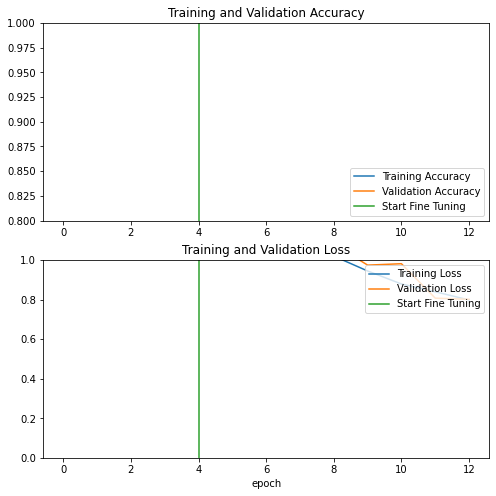

In [75]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [76]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 225, 225, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 225, 225, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 225, 225, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                           

# By build a convolutional neural network (ConvNet), then use transfer learning and fine tuning to improve the model
# The initial model has an accuracy of accuracy: 0.922
# While testing and  fine tuning the model we got an accuracy of 0.74